# Handwriting prediction using LSTM RNN
Loading libraries

In [1]:
import os
import pickle
import random
import xml.etree.ElementTree as ET

import numpy as np
import svgwrite
from IPython.display import SVG, display

import torch
from torch import nn, optim
import torch.nn.functional as F
use_cuda = False
use_cuda = torch.cuda.is_available()

import time

n_batch = 20
sequence_length = 300

hidden_size = 256
n_layers = 3
n_gaussians = 10

eps = float(np.finfo(np.float32).eps)

# Hyperparameters
gradient_threshold = 10
dropout = 0.2



torch.cuda.empty_cache()

## Dataloader
This code comes from https://raw.githubusercontent.com/hardmaru/write-rnn-tensorflow/master/utils.py. Big thanks to his author

In [2]:
def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

# old version, where each path is entire stroke (smaller svg size, but
# have to keep same color)


def draw_strokes(data, factor=10, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "

    the_color = "black"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    display(SVG(dwg.tostring()))


def draw_strokes_eos_weighted(
        stroke,
        param,
        factor=10,
        svg_filename='sample_eos.svg'):
    c_data_eos = np.zeros((len(stroke), 3))
    for i in range(len(param)):
        # make color gray scale, darker = more likely to eos
        c_data_eos[i, :] = (1 - param[i][6][0]) * 225
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data_eos,
        stroke_width=3)


def draw_strokes_random_color(
        stroke,
        factor=10,
        svg_filename='sample_random_color.svg',
        per_stroke_mode=True):
    c_data = np.array(np.random.rand(len(stroke), 3) * 240, dtype=np.uint8)
    if per_stroke_mode:
        switch_color = False
        for i in range(len(stroke)):
            if switch_color == False and i > 0:
                c_data[i] = c_data[i - 1]
            if stroke[i, 2] < 1:  # same strike
                switch_color = False
            else:
                switch_color = True
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data,
        stroke_width=2)


def draw_strokes_custom_color(
        data,
        factor=10,
        svg_filename='test.svg',
        color_data=None,
        stroke_width=1):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1
    abs_x = 25 - min_x
    abs_y = 25 - min_y

    for i in range(len(data)):

        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor

        prev_x = abs_x
        prev_y = abs_y

        abs_x += x
        abs_y += y

        if (lift_pen == 1):
            p = "M " + str(abs_x) + "," + str(abs_y) + " "
        else:
            p = "M +" + str(prev_x) + "," + str(prev_y) + \
                " L " + str(abs_x) + "," + str(abs_y) + " "

        lift_pen = data[i, 2]

        the_color = "black"

        if (color_data is not None):
            the_color = "rgb(" + str(int(color_data[i, 0])) + "," + str(
                int(color_data[i, 1])) + "," + str(int(color_data[i, 2])) + ")"

        dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill(the_color))
    dwg.save()
    display(SVG(dwg.tostring()))


class DataLoader():
    def __init__(
            self,
            batch_size=50,
            seq_length=300,
            scale_factor=10,
            limit=500):
        self.data_dir = "./data"
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.scale_factor = scale_factor  # divide data by this factor
        self.limit = limit  # removes large noisy gaps in the data

        data_file = os.path.join(self.data_dir, "strokes_training_data.cpkl")
        raw_data_dir = self.data_dir + "/lineStrokes"

        if not (os.path.exists(data_file)):
            print("creating training data pkl file from raw source")
            self.preprocess(raw_data_dir, data_file)

        self.load_preprocessed(data_file)
        self.reset_batch_pointer()

    def preprocess(self, data_dir, data_file):
        # create data file from raw xml files from iam handwriting source.

        # build the list of xml files
        filelist = []
        # Set the directory you want to start from
        rootDir = data_dir
        for dirName, subdirList, fileList in os.walk(rootDir):
            #print('Found directory: %s' % dirName)
            for fname in fileList:
                #print('\t%s' % fname)
                filelist.append(dirName + "/" + fname)

        # function to read each individual xml file
        def getStrokes(filename):
            tree = ET.parse(filename)
            root = tree.getroot()

            result = []

            x_offset = 1e20
            y_offset = 1e20
            y_height = 0
            for i in range(1, 4):
                x_offset = min(x_offset, float(root[0][i].attrib['x']))
                y_offset = min(y_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            y_height -= y_offset
            x_offset -= 100
            y_offset -= 100

            for stroke in root[1].findall('Stroke'):
                points = []
                for point in stroke.findall('Point'):
                    points.append(
                        [float(point.attrib['x']) - x_offset, float(point.attrib['y']) - y_offset])
                result.append(points)

            return result

        # converts a list of arrays into a 2d numpy int16 array
        def convert_stroke_to_array(stroke):

            n_point = 0
            for i in range(len(stroke)):
                n_point += len(stroke[i])
            stroke_data = np.zeros((n_point, 3), dtype=np.int16)

            prev_x = 0
            prev_y = 0
            counter = 0

            for j in range(len(stroke)):
                for k in range(len(stroke[j])):
                    stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
                    stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
                    prev_x = int(stroke[j][k][0])
                    prev_y = int(stroke[j][k][1])
                    stroke_data[counter, 2] = 0
                    if (k == (len(stroke[j]) - 1)):  # end of stroke
                        stroke_data[counter, 2] = 1
                    counter += 1
            return stroke_data

        # build stroke database of every xml file inside iam database
        strokes = []
        for i in range(len(filelist)):
            if (filelist[i][-3:] == 'xml'):
                print('processing ' + filelist[i])
                strokes.append(
                    convert_stroke_to_array(
                        getStrokes(
                            filelist[i])))

        f = open(data_file, "wb")
        pickle.dump(strokes, f, protocol=2)
        f.close()

    def load_preprocessed(self, data_file):
        f = open(data_file, "rb")
        self.raw_data = pickle.load(f)
        f.close()

        # goes thru the list, and only keeps the text entries that have more
        # than seq_length points
        self.data = []
        self.valid_data = []
        counter = 0

        # every 1 in 20 (5%) will be used for validation data
        cur_data_counter = 0
        for data in self.raw_data:
            if len(data) > (self.seq_length + 2):
                # removes large gaps from the data
                data = np.minimum(data, self.limit)
                data = np.maximum(data, -self.limit)
                data = np.array(data, dtype=np.float32)
                data[:, 0:2] /= self.scale_factor
                cur_data_counter = cur_data_counter + 1
                if cur_data_counter % 20 == 0:
                    self.valid_data.append(data)
                else:
                    self.data.append(data)
                    # number of equiv batches this datapoint is worth
                    counter += int(len(data) / ((self.seq_length + 2)))

        print("train data: {}, valid data: {}".format(
            len(self.data), len(self.valid_data)))
        # minus 1, since we want the ydata to be a shifted version of x data
        self.num_batches = int(counter / self.batch_size)

    def validation_data(self):
        # returns validation data
        x_batch = []
        y_batch = []
        for i in range(self.batch_size):
            data = self.valid_data[i % len(self.valid_data)]
            idx = 0
            x_batch.append(np.copy(data[idx:idx + self.seq_length]))
            y_batch.append(np.copy(data[idx + 1:idx + self.seq_length + 1]))
        return x_batch, y_batch

    def next_batch(self):
        # returns a randomised, seq_length sized portion of the training data
        x_batch = []
        y_batch = []
        for i in range(self.batch_size):
            data = self.data[self.pointer]
            # number of equiv batches this datapoint is worth
            n_batch = int(len(data) / ((self.seq_length + 2)))
            idx = random.randint(0, len(data) - self.seq_length - 2)
            x_batch.append(np.copy(data[idx:idx + self.seq_length]))
            y_batch.append(np.copy(data[idx + 1:idx + self.seq_length + 1]))
            # adjust sampling probability.
            if random.random() < (1.0 / float(n_batch)):
                # if this is a long datapoint, sample this data more with
                # higher probability
                self.tick_batch_pointer()
        return x_batch, y_batch

    def tick_batch_pointer(self):
        self.pointer += 1
        if (self.pointer >= len(self.data)):
            self.pointer = 0

    def reset_batch_pointer(self):
        self.pointer = 0


Showing random data from dataset using the DataLoader class

In [1]:
'''
for i in range(5):
    draw_strokes(random.choice(data_loader.raw_data))
'''
'''
sample = random.choice(data_loader.raw_data)
draw_strokes_random_color(sample, per_stroke_mode = False)
draw_strokes_random_color(sample)
'''



'\nsample = random.choice(data_loader.raw_data)\ndraw_strokes_random_color(sample, per_stroke_mode = False)\ndraw_strokes_random_color(sample)\n'

## Handwriting generation with PyTorch
input layer dimension is [sequence_size, batch_size, 3]

In [4]:
# Creating the model

class HandwritingGenerationModel(nn.Module):
    def __init__(self, hidden_size = 256, n_layers = 3, n_gaussians = 10, dropout = 0):
        super(HandwritingGenerationModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_gaussians = n_gaussians
        
        self.lstm = nn.LSTM(input_size = 3, hidden_size = hidden_size, num_layers = n_layers, dropout = dropout)
        
        self.z_e = nn.Linear(hidden_size, 1)
        self.z_pi = nn.Linear(hidden_size, n_gaussians)
        self.z_mu1 = nn.Linear(hidden_size, n_gaussians)
        self.z_mu2 = nn.Linear(hidden_size, n_gaussians)
        self.z_sigma1 = nn.Linear(hidden_size, n_gaussians)
        self.z_sigma2 = nn.Linear(hidden_size, n_gaussians)
        self.z_rho = nn.Linear(hidden_size, n_gaussians)
        
    def forward(self, x, hidden = None):
        # number of batches
        n_batch = x.shape[0]
        
        out, hidden = self.lstm(x, hidden) 
        # print("out shape ", out.shape) # torch.Size([sequence_length, batch, hidden_size])

        es = self.z_e(out)
        # print("es shape ", es.shape) # -> torch.Size([sequence_length, batch, 1])
        es = 1 / (1 + torch.exp(es))
        # print("es shape", es.shape) # -> torch.Size([sequence_length, batch, 1])

        pis = self.z_pi(out)
        # print("pis shape ", pis.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        pis = torch.softmax(pis, 2)
        # print(pi.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        mu1s = self.z_mu1(out)
        mu2s = self.z_mu2(out)
        # print("mu shape :  ", mu1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        sigma1s = self.z_sigma1(out)
        sigma2s = self.z_sigma2(out)
        # print("sigmas shape ", sigma1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        sigma1s = torch.exp(sigma1s)
        sigma2s = torch.exp(sigma2s)
        # print(sigma1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        rhos = self.z_rho(out)
        rhos = torch.tanh(rhos)
        # print("rhos shape ", rhos.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        es = es.squeeze(2) 
        # print("es shape ", es.shape) # -> torch.Size([sequence_length, batch])

        
        return es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos
    
            
    def generate_sample(self, mu1, mu2, sigma1, sigma2, rho):
        mean = [mu1, mu2]
        cov = [[sigma1 ** 2, rho * sigma1 * sigma2], [rho * sigma1 * sigma2, sigma2 ** 2]]
        
        x = np.float32(np.random.multivariate_normal(mean, cov, 1))
        return torch.from_numpy(x)
        
        
    def generate_sequence(self, x0, sequence_length = 100):
        sequence = x0
        
        for i in range(sequence_length):
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = self.forward(sequence)
            
            # Selecting a mixture 
            pi_idx = np.random.choice(range(self.n_gaussians), p=pis[-1, 0, :].detach().cpu().numpy())
            
            # taking last parameters from sequence corresponding to chosen gaussian
            mu1 = mu1s[-1, :, pi_idx].item()
            mu2 = mu2s[-1, :, pi_idx].item()
            sigma1 = sigma1s[-1, :, pi_idx].item()
            sigma2 = sigma2s[-1, :, pi_idx].item()
            rho = rhos[-1, :, pi_idx].item()
            
            prediction = self.generate_sample(mu1, mu2, sigma1, sigma2, rho)
            eos = torch.distributions.bernoulli.Bernoulli(torch.tensor([es[-1, :].item()])).sample()
            
            sample = torch.zeros_like(x0) # torch.Size([1, 1, 3])
            sample[0, 0, 0] = prediction[0, 0]
            sample[0, 0, 1] = prediction[0, 1]
            sample[0, 0, 2] = eos
            
            sequence = torch.cat((sequence, sample), 0) # torch.Size([sequence_length, 1, 3])
        
        return sequence.squeeze(1).detach().cpu().numpy()
                     
    

## Implementing density probability
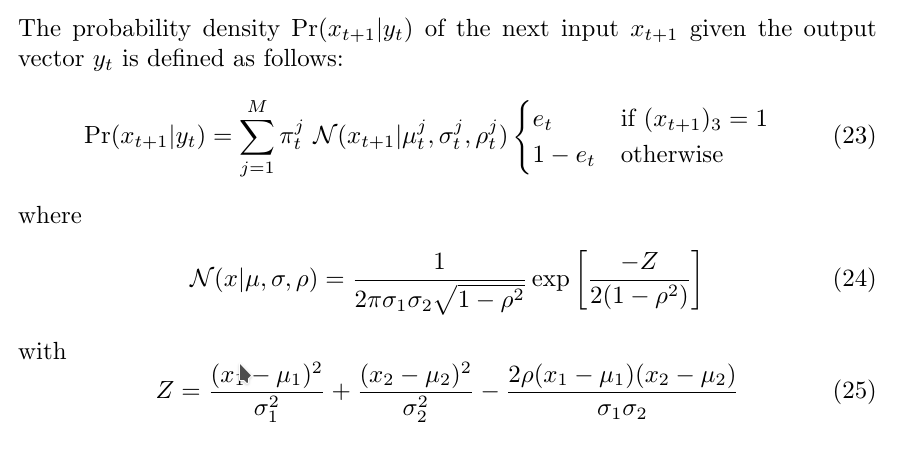


In [5]:
def gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos):
    n_mixtures = pis.size(2)
    
    # Takes x1 and repeats it over the number of gaussian mixtures
    x1 = y[:,:, 0].repeat(n_mixtures, 1, 1).permute(1, 2, 0) 
    # print("x1 shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # first term of Z (eq 25)
    x1norm = ((x1 - mu1s) ** 2) / (sigma1s ** 2 )
    # print("x1norm shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    x2 = y[:,:, 1].repeat(n_mixtures, 1, 1).permute(1, 2, 0)  
    # print("x2 shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # second term of Z (eq 25)
    x2norm = ((x2 - mu2s) ** 2) / (sigma2s ** 2 )
    # print("x2norm shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # third term of Z (eq 25)
    coxnorm = 2 * rhos * (x1 - mu1s) * (x2 - mu2s) / (sigma1s * sigma2s) 
    
    # Computing Z (eq 25)
    Z = x1norm + x2norm - coxnorm
    
    # Gaussian bivariate (eq 24)
    N = torch.exp(-Z / (2 * (1 - rhos ** 2))) / (2 * np.pi * sigma1s * sigma2s * (1 - rhos ** 2) ** 0.5) 
    # print("N shape ", N.shape) # -> torch.Size([sequence_length, batch, n_gaussians]) 
    
    # Pr is the result of eq 23 without the eos part
    Pr = pis * N 
    # print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch, n_gaussians])   
    Pr = torch.sum(Pr, dim=2) 
    # print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch])   
    
    if use_cuda:
        Pr = Pr.cuda()
    
    return Pr
    
    

In [6]:
# es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = model.forward(x)
# gaussianMixture(x, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)

## Computing loss fn
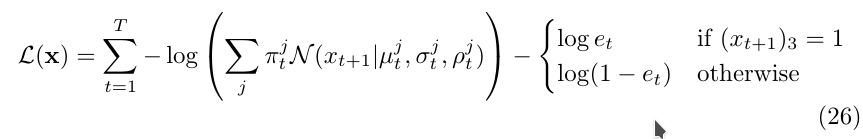

In [7]:
def loss_fn(Pr, y, es):
    loss1 = - torch.log(Pr + eps) # -> torch.Size([sequence_length, batch])    
    bernouilli = torch.zeros_like(es) # -> torch.Size([sequence_length, batch])
    
    bernouilli = y[:, :, 2] * es + (1 - y[:, :, 2]) * (1 - es)
    
    loss2 = - torch.log(bernouilli + eps)
    loss = loss1 + loss2 
    # print("loss shape", loss.shape) # -> torch.Size([sequence_length, batch])  
    loss = torch.sum(loss, 0) 
    # print("loss shape", loss.shape) # -> torch.Size([batch]) 
    
    return torch.mean(loss);
    
    

In [26]:
def train_network():
    data_loader = DataLoader(n_batch, sequence_length, 20) # 20 = datascale
    model = HandwritingGenerationModel(hidden_size, n_layers, n_gaussians, dropout)
    
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    if use_cuda:
        model = model.cuda()
        
    for epoch in range(10):
        data_loader.reset_batch_pointer()
        
        for batch in range(data_loader.num_batches):
            start = time.time()
            
            x, y = data_loader.next_batch()
            x = np.float32(np.array(x)) # -> (n_batch, sequence_length, 3)
            y = np.float32(np.array(y)) # -> (n_batch, sequence_length, 3)

            x = torch.from_numpy(x).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
            y = torch.from_numpy(y).permute(1, 0, 2)
            
            if use_cuda:
                x = x.cuda()
                y = y.cuda()
            
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = model.forward(x)

            Pr = gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)
            loss = loss_fn(Pr,y, es)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_threshold)
            optimizer.step()
            
            if batch % 100 == 0:
                print("Epoch : ", epoch, " - step ", batch, "/", data_loader.num_batches, " - loss ", loss.item(), " in ", time.time() - start)
                x0 = torch.Tensor([0,0,1]).view(1,1,3)

                if use_cuda:
                    x0 = x0.cuda()

                sequence = model.generate_sequence(x0, sequence_length = 300)
                draw_strokes_random_color(sequence, factor=0.5)

train data: 11035, valid data: 580
Epoch :  0  - step  0 / 911  - loss  1107.603271484375  in  0.15668416023254395


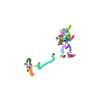

Epoch :  0  - step  100 / 911  - loss  355.64630126953125  in  0.13982295989990234


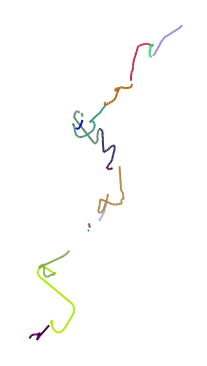

Epoch :  0  - step  200 / 911  - loss  256.072509765625  in  0.13981342315673828


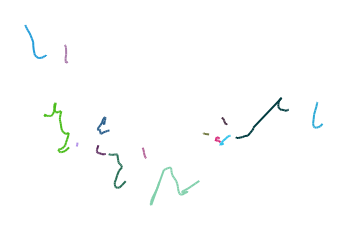

Epoch :  0  - step  300 / 911  - loss  87.51262664794922  in  0.13768649101257324


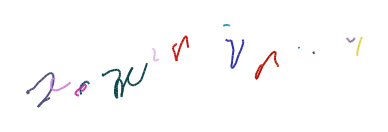

Epoch :  0  - step  400 / 911  - loss  104.55023193359375  in  0.1401510238647461


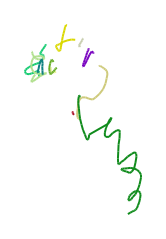

Epoch :  0  - step  500 / 911  - loss  191.86973571777344  in  0.14896082878112793


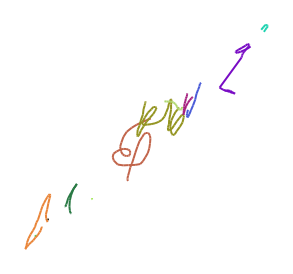

Epoch :  0  - step  600 / 911  - loss  344.43408203125  in  0.15235018730163574


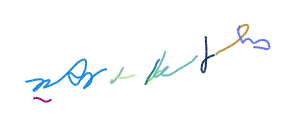

Epoch :  0  - step  700 / 911  - loss  99.23299407958984  in  0.1534883975982666


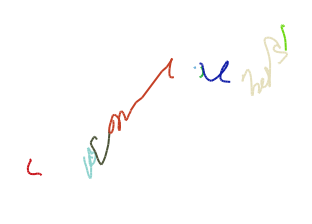

Epoch :  0  - step  800 / 911  - loss  198.06256103515625  in  0.16841650009155273


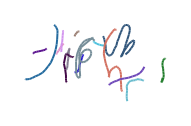

Epoch :  0  - step  900 / 911  - loss  73.95195770263672  in  0.1561894416809082


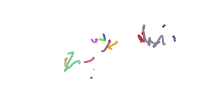

Epoch :  1  - step  0 / 911  - loss  92.39949035644531  in  0.14141511917114258


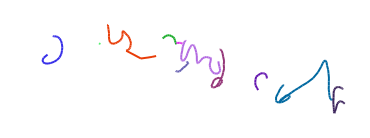

Epoch :  1  - step  100 / 911  - loss  -33.85679626464844  in  0.15556931495666504


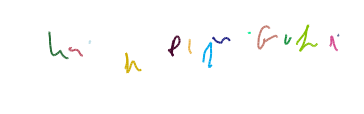

Epoch :  1  - step  200 / 911  - loss  93.93807220458984  in  0.15615606307983398


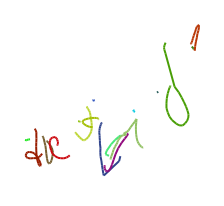

Epoch :  1  - step  300 / 911  - loss  213.70310974121094  in  0.15920710563659668


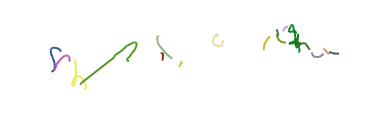

Epoch :  1  - step  400 / 911  - loss  23.7325496673584  in  0.170149564743042


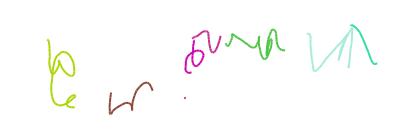

Epoch :  1  - step  500 / 911  - loss  105.23963928222656  in  0.15882158279418945


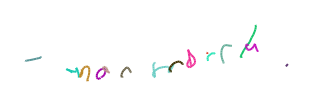

Epoch :  1  - step  600 / 911  - loss  164.26304626464844  in  0.16160368919372559


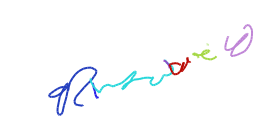

Epoch :  1  - step  700 / 911  - loss  125.68685150146484  in  0.18873810768127441


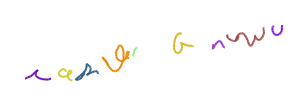

Epoch :  1  - step  800 / 911  - loss  3.417163133621216  in  0.15842676162719727


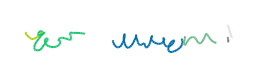

Epoch :  1  - step  900 / 911  - loss  9.936545372009277  in  0.16574859619140625


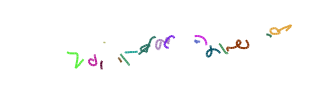

Epoch :  2  - step  0 / 911  - loss  4.097789287567139  in  0.14458799362182617


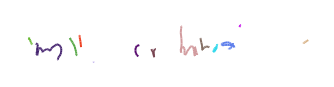

Epoch :  2  - step  100 / 911  - loss  -32.54304885864258  in  0.15922832489013672


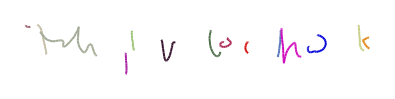

Epoch :  2  - step  200 / 911  - loss  -70.12741088867188  in  0.16339683532714844


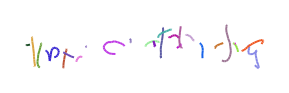

Epoch :  2  - step  300 / 911  - loss  236.2164306640625  in  0.17623543739318848


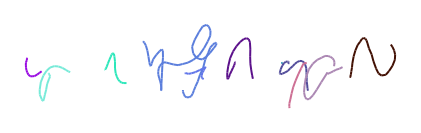

Epoch :  2  - step  400 / 911  - loss  -65.80428314208984  in  0.1850588321685791


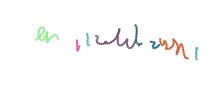

Epoch :  2  - step  500 / 911  - loss  -25.25885581970215  in  0.1596839427947998


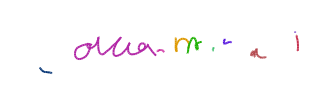

Epoch :  2  - step  600 / 911  - loss  -43.67533493041992  in  0.1635279655456543


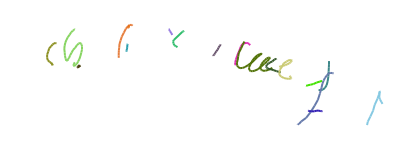

Epoch :  2  - step  700 / 911  - loss  110.47176361083984  in  0.16252970695495605


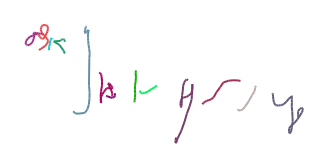

Epoch :  2  - step  800 / 911  - loss  1.3302528858184814  in  0.16392970085144043


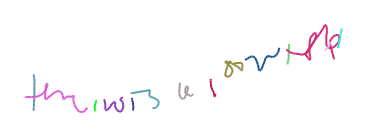

Epoch :  2  - step  900 / 911  - loss  82.9773941040039  in  0.1642284393310547


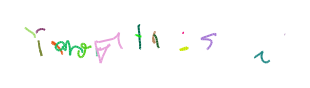

Epoch :  3  - step  0 / 911  - loss  -182.50172424316406  in  0.14385390281677246


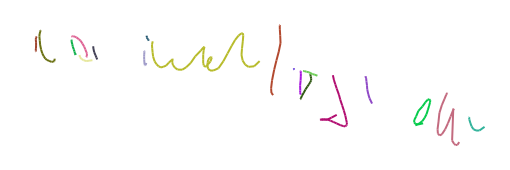

Epoch :  3  - step  100 / 911  - loss  -79.61595916748047  in  0.16193771362304688


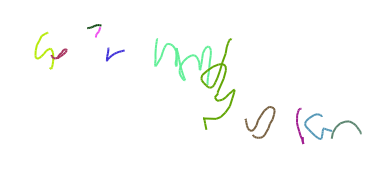

Epoch :  3  - step  200 / 911  - loss  45.41101837158203  in  0.15985989570617676


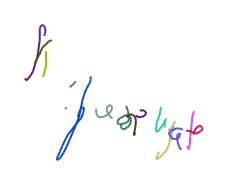

Epoch :  3  - step  300 / 911  - loss  6.934319972991943  in  0.1612107753753662


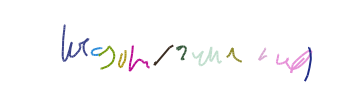

Epoch :  3  - step  400 / 911  - loss  6.998967170715332  in  0.16798186302185059


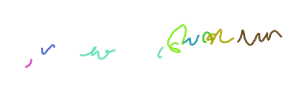

Epoch :  3  - step  500 / 911  - loss  -173.46591186523438  in  0.1970987319946289


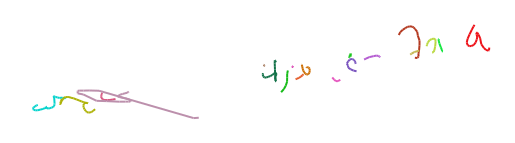

Epoch :  3  - step  600 / 911  - loss  -55.684783935546875  in  0.16734886169433594


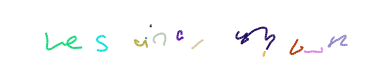

Epoch :  3  - step  700 / 911  - loss  57.463783264160156  in  0.16902828216552734


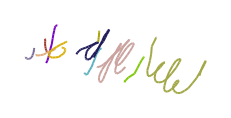

Epoch :  3  - step  800 / 911  - loss  -80.75033569335938  in  0.16479802131652832


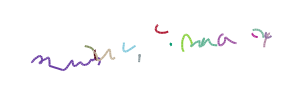

Epoch :  3  - step  900 / 911  - loss  80.78909301757812  in  0.18725132942199707


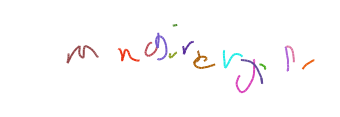

Epoch :  4  - step  0 / 911  - loss  -16.142629623413086  in  0.14445090293884277


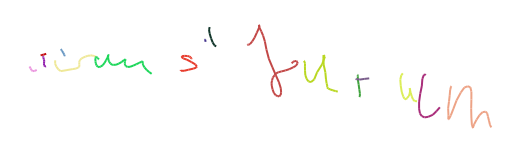

Epoch :  4  - step  100 / 911  - loss  24.463491439819336  in  0.16099166870117188


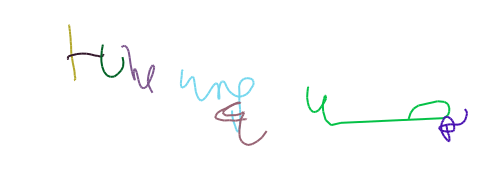

Epoch :  4  - step  200 / 911  - loss  37.38177490234375  in  0.16451311111450195


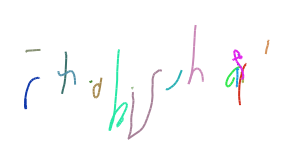

Epoch :  4  - step  300 / 911  - loss  47.49418258666992  in  0.16536998748779297


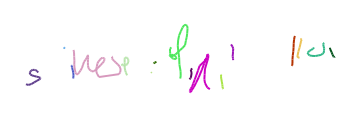

Epoch :  4  - step  400 / 911  - loss  -2.611818552017212  in  0.16307711601257324


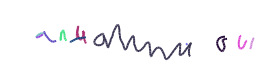

Epoch :  4  - step  500 / 911  - loss  -160.62945556640625  in  0.16337156295776367


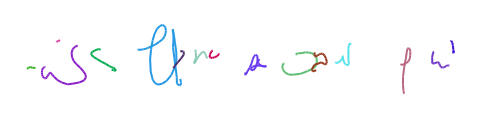

Epoch :  4  - step  600 / 911  - loss  131.2256317138672  in  0.16358542442321777


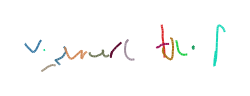

Epoch :  4  - step  700 / 911  - loss  -37.92564010620117  in  0.16250991821289062


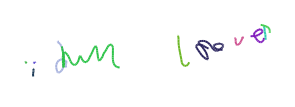

Epoch :  4  - step  800 / 911  - loss  39.84877395629883  in  0.16498184204101562


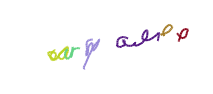

Epoch :  4  - step  900 / 911  - loss  -119.34110260009766  in  0.1643664836883545


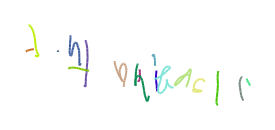

Epoch :  5  - step  0 / 911  - loss  -32.779945373535156  in  0.14525675773620605


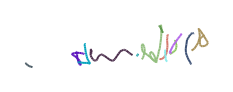

Epoch :  5  - step  100 / 911  - loss  -153.967529296875  in  0.16590046882629395


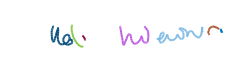

Epoch :  5  - step  200 / 911  - loss  94.32612609863281  in  0.16486740112304688


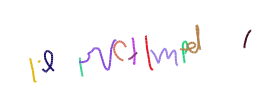

Epoch :  5  - step  300 / 911  - loss  141.1770477294922  in  0.16466689109802246


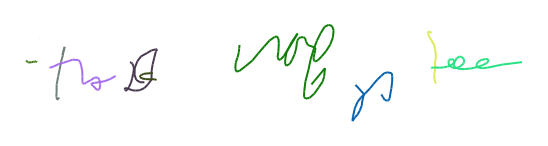

Epoch :  5  - step  400 / 911  - loss  -18.52057456970215  in  0.16465330123901367


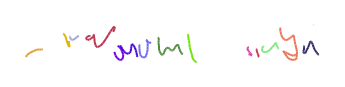

Epoch :  5  - step  500 / 911  - loss  23.965797424316406  in  0.16497063636779785


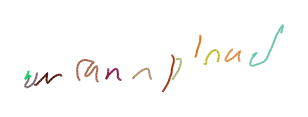

Epoch :  5  - step  600 / 911  - loss  -53.684749603271484  in  0.16342639923095703


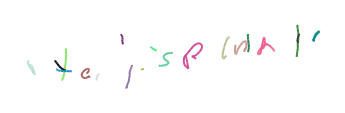

Epoch :  5  - step  700 / 911  - loss  89.1397476196289  in  0.1649932861328125


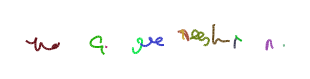

Epoch :  5  - step  800 / 911  - loss  -79.32034301757812  in  0.16394853591918945


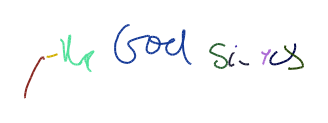

Epoch :  5  - step  900 / 911  - loss  -120.08026123046875  in  0.167374849319458


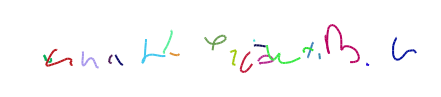

Epoch :  6  - step  0 / 911  - loss  -35.78551483154297  in  0.1437695026397705


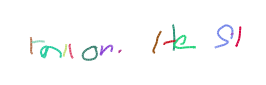

Epoch :  6  - step  100 / 911  - loss  -29.75535011291504  in  0.16257476806640625


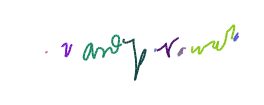

Epoch :  6  - step  200 / 911  - loss  43.13853073120117  in  0.15997886657714844


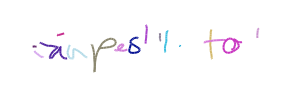

Epoch :  6  - step  300 / 911  - loss  -75.42400360107422  in  0.16347479820251465


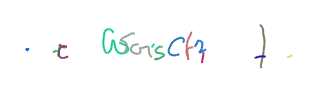

Epoch :  6  - step  400 / 911  - loss  -29.9487361907959  in  0.16422128677368164


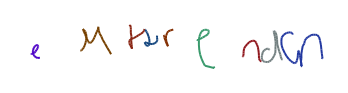

Epoch :  6  - step  500 / 911  - loss  -43.72788619995117  in  0.16395258903503418


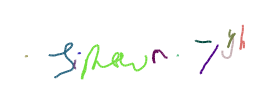

Epoch :  6  - step  600 / 911  - loss  -113.15968322753906  in  0.16307950019836426


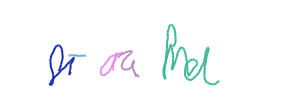

Epoch :  6  - step  700 / 911  - loss  80.65373992919922  in  0.165513277053833


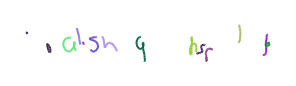

Epoch :  6  - step  800 / 911  - loss  -121.17525482177734  in  0.16587424278259277


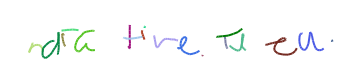

Epoch :  6  - step  900 / 911  - loss  31.163394927978516  in  0.16471219062805176


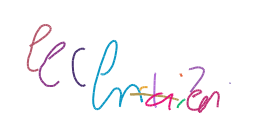

Epoch :  7  - step  0 / 911  - loss  -161.7465362548828  in  0.15366840362548828


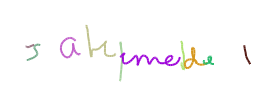

Epoch :  7  - step  100 / 911  - loss  -39.351497650146484  in  0.1698315143585205


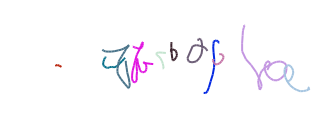

Epoch :  7  - step  200 / 911  - loss  -125.1343765258789  in  0.17072391510009766


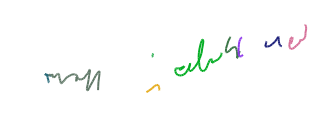

Epoch :  7  - step  300 / 911  - loss  26.3457088470459  in  0.18999195098876953


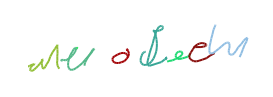

Epoch :  7  - step  400 / 911  - loss  -27.446760177612305  in  0.17444348335266113


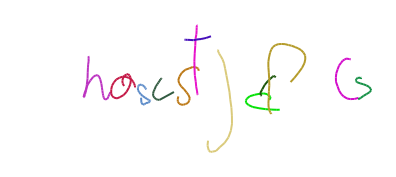

KeyboardInterrupt: 

In [27]:
train_network()

train data: 11035, valid data: 580


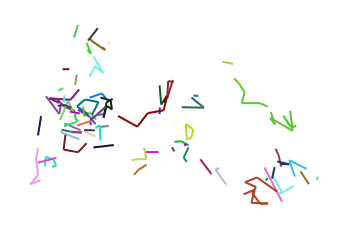

In [25]:
data_loader = DataLoader(n_batch, sequence_length, 20) # 20 = datascale
model = HandwritingGenerationModel(hidden_size, n_layers, n_gaussians, dropout)

x, y = data_loader.next_batch()
x = np.float32(np.array(x)) # -> (n_batch, sequence_length, 3)
y = np.float32(np.array(y)) # -> (n_batch, sequence_length, 3)

x = torch.from_numpy(x).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
y = torch.from_numpy(y).permute(1, 0, 2)

if use_cuda:
    model = model.cuda()
    x = x.cuda()
    y = y.cuda()

es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = model.forward(x)

Pr = gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)
loss = loss_fn(Pr,y, es)

x0 = torch.Tensor([0,0,1]).view(1,1,3)

if use_cuda:
    x0 = x0.cuda()

sequence = model.generate_sequence(x0, sequence_length = 300)
draw_strokes_random_color(sequence, factor=0.5)
